# Analyze dwell times

Chris Kimmel | kimmel.95@osu.edu | 8/10/2020

Alice says the nucleotides at these positions may be modified:
* 8079
* 8710
* 8975

Alice uses one-based indexing, but Tombo and my scripts use zero-based indexing.

The purpose of this notebook is to determine whether dwell-time data supports the hypothesis that these three nucleotides are modified.
We will look for distributional dwell-time differences at those nucleotide positions.
We will also look for distributional dwell-time differences 10 nucleotides downstream (higher position number) of those sites.

As input, this script uses CSV files of per-read per-position dwell times.
They are stored in this directory on the Ohio Supercomputer filesystem:
```
/fs/project/PAS1405/extract_dwells_3
```
There are several datasets in that directory, but we will focus on just two.
`Trizol_A` is our experimental dataset, originating from HIV RNA that was harvested from cells.
`f1f2_GL` is a our negative control dataset, originating from otherwise similar strands of IVT RNA.

In [95]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
ctrl_path = "/fs/project/PAS1405/extract_dwells_3/f1f2_GL_dwells.csv"
exp_path = "/fs/project/PAS1405/extract_dwells_3/Trizol_A_8K_single_fast5_dwells.csv"

read_csv_settings = {
    'header': 0,
    'index_col': 0
}

ctrl_df = pd.read_csv(ctrl_path, **read_csv_settings)
exp_df = pd.read_csv(exp_path, **read_csv_settings)

In [2]:
ctrl_df.columns = ctrl_df.columns.astype(int)
exp_df.columns = exp_df.columns.astype(int)

In [45]:
display(ctrl_df.info())
print('')
print(ctrl_df.columns.dtype)
print(ctrl_df.index.dtype)

<class 'pandas.core.frame.DataFrame'>
Index: 105821 entries, 7eea708e-b3e2-4bda-b986-d2611ae50e5c to 8a3dc2d4-e87b-4c1c-ba11-1fc194153bd4
Columns: 9170 entries, 1 to 9170
dtypes: float64(9170)
memory usage: 7.2+ GB


None


int64
object


In [62]:
pos_intersection = ctrl_df.columns.intersection(exp_df.columns)

In [64]:
dwell_ks_stats = pd.Series(index=pos_intersection, dtype=float)
dwell_ks_pvals = pd.Series(index=pos_intersection, dtype=float)
for pos in pos_intersection:
    ctrl_col = ctrl_df.loc[:, pos].dropna()
    exp_col = exp_df.loc[:, pos].dropna()
    statistic, pvalue = stats.ks_2samp(ctrl_col, exp_col)
    dwell_ks_stats.loc[pos] = statistic
    dwell_ks_pvals.loc[pos] = pvalue

In [167]:
# Save progress
dwell_df = pd.DataFrame(
    {'ks_stat': dwell_ks_stats, 'ks_pval': dwell_ks_pvals}
).rename_axis('pos', axis=0)

import pickle
fname = 'saved_dwell_ks_stats.p'
with open(fname, 'wb') as file:
    pickle.dump(dwell_df, file, protocol=2)
with open(fname, 'rb') as file:
    display(pickle.load(file))

,ks_pval,ks_stat
pos,,
9,3.463870e-01,0.760083
10,6.372140e-01,0.604912
11,9.099745e-02,0.516798
12,3.573255e-01,0.385174
13,2.315587e-05,0.592903
14,7.647191e-18,0.426000
15,2.636243e-09,0.229658
16,6.915641e-02,0.092212
17,5.728625e-03,0.118116


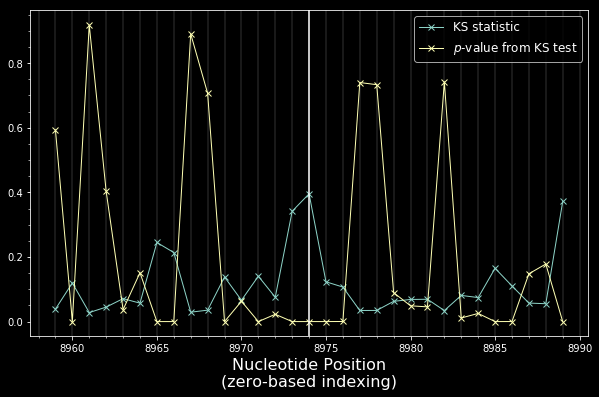

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

center, radius = 8974, 15
data_of_interest = dwell_df.loc[center - radius : center + radius]
x = data_of_interest.index
y = data_of_interest

formatting_args = {'linestyle': '-', 'marker': 'x', 'linewidth':1}
ax.plot(x, y['ks_stat'], label='KS statistic', **formatting_args)
ax.plot(x, y['ks_pval'], label='$p$-value from KS test', **formatting_args)

ax.minorticks_on()
plt.grid(True, which='both', axis='x', linewidth='0.2') #, axis='y', which='minor', color='r')

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Nucleotide Position\n(zero-based indexing)', fontsize=16)

plt.axvline([center])

# plt.savefig('KS_plot_nt8975.png')
plt.show()

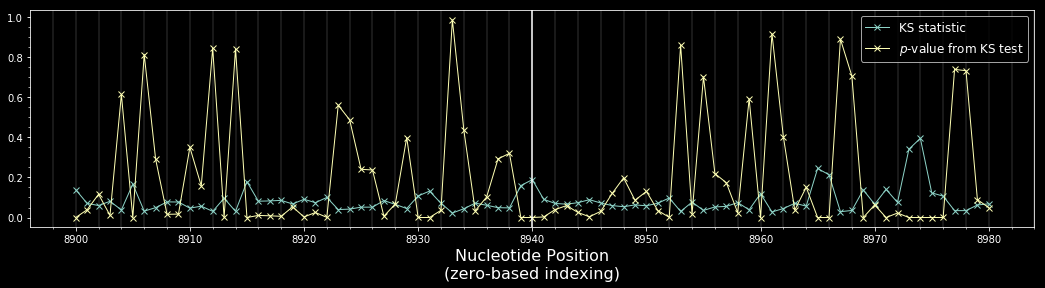

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))

center, radius = 8940, 40 # 8078 8709 8974
data_of_interest = dwell_df.loc[center - radius : center + radius]
x = data_of_interest.index
y = data_of_interest

formatting_args = {'linestyle': '-', 'marker': 'x', 'linewidth':1}
ax.plot(x, y['ks_stat'], label='KS statistic', **formatting_args)
ax.plot(x, y['ks_pval'], label='$p$-value from KS test', **formatting_args)

ax.minorticks_on()
plt.grid(True, which='both', axis='x', linewidth='0.2') #, axis='y', which='minor', color='r')

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Nucleotide Position\n(zero-based indexing)', fontsize=16)

plt.axvline([center])

plt.show()

In [270]:
dwell_u_tests = pd.DataFrame(index=pos_intersection, columns=['stat', 'pval'], dtype=float)
for pos in pos_intersection:
    ctrl_col = ctrl_df.loc[:, pos].dropna()
    exp_col = exp_df.loc[:, pos].dropna()
    statistic, pvalue = stats.mannwhitneyu(ctrl_col, exp_col)
    dwell_u_tests.loc[pos, 'stat'] = statistic
    dwell_u_tests.loc[pos, 'pval'] = pvalue

In [271]:
dwell_u_tests

,stat,pval
9,9593.5,1.762789e-01
10,17506.0,3.527373e-01
11,52545.0,1.472370e-02
12,100106.5,2.531978e-01
13,117982.5,2.363624e-06
14,1409403.5,1.979485e-18
15,3282982.5,2.645402e-16
16,4418849.5,2.550311e-03
17,4654360.5,1.031078e-03
18,5340008.5,1.071629e-03


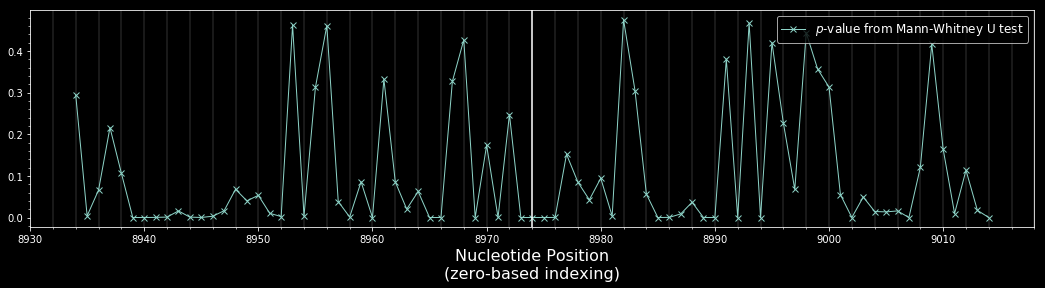

In [277]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))

center, radius = 8974, 40 # 8078 8709 8974
data_of_interest = dwell_u_tests.loc[center - radius : center + radius, :]
x = data_of_interest.index
y = data_of_interest

formatting_args = {'linestyle': '-', 'marker': 'x', 'linewidth':1}
ax.plot(x, y['pval'], label='$p$-value from Mann-Whitney U test', **formatting_args)

ax.minorticks_on()
plt.grid(True, which='both', axis='x', linewidth='0.2') #, axis='y', which='minor', color='r')

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Nucleotide Position\n(zero-based indexing)', fontsize=16)

plt.axvline([center])

plt.show()

In [290]:
dwell_u_test_pvals_smoothed = (
    dwell_u_tests.loc[:, 'pval']
    .rolling(5, center=True, win_type='boxcar')
).mean()


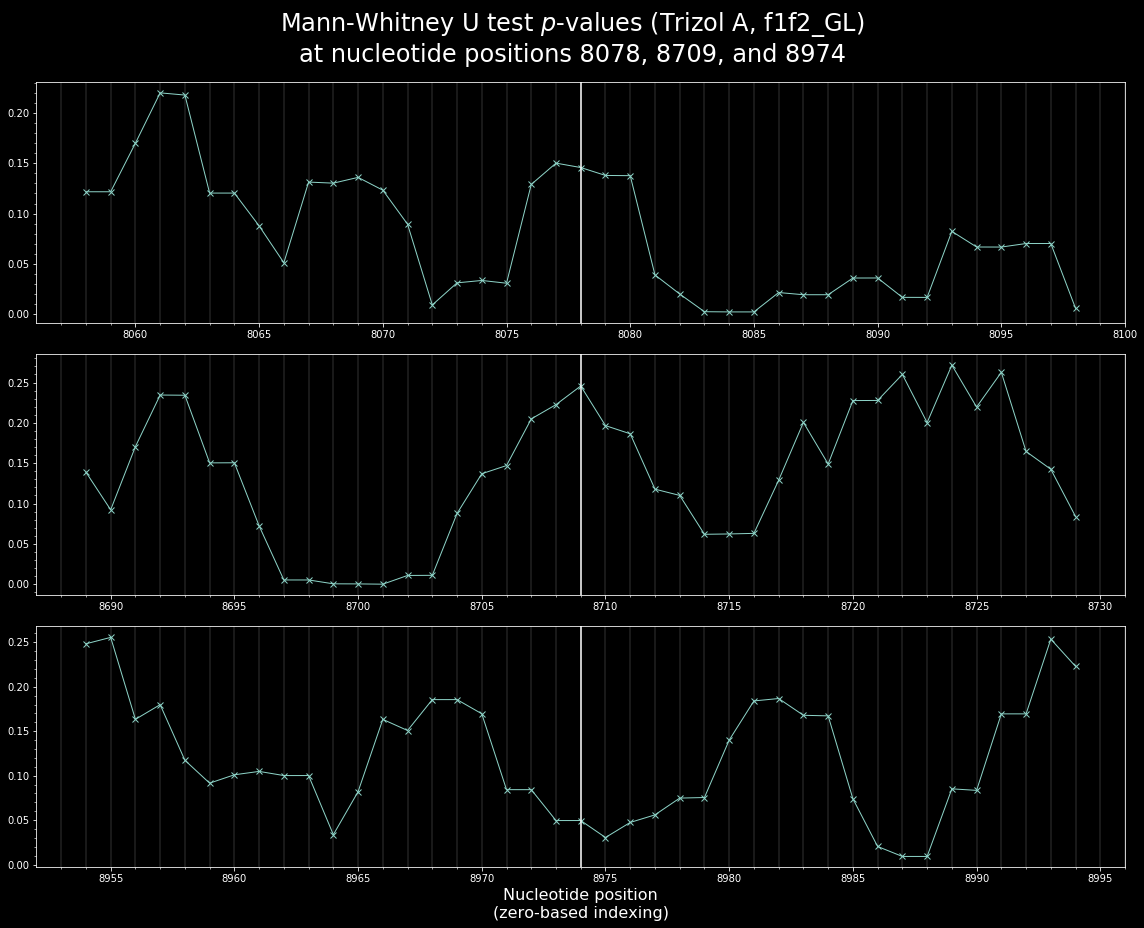

In [340]:
centers = [8078, 8709, 8974]
n = len(centers)

fig, axes = plt.subplots(n, 1, figsize=(16,4*n))

for center, ax in zip(centers, axes):
    radius = 20
    data_of_interest = dwell_u_test_pvals_smoothed.loc[center - radius : center + radius]
    x = data_of_interest.index
    y = data_of_interest

    formatting_args = {'linestyle': '-', 'marker': 'x', 'linewidth':1}
    ax.plot(x, y, label='SMOOTHED $p$-value from Mann-Whitney U test', **formatting_args)

    ax.minorticks_on()
    
    ax.grid(True, which='both', axis='x', linewidth='0.2') #, axis='y', which='minor', color='r')
    
    ax.axvline([center])
    
plt.xlabel('Nucleotide position\n(zero-based indexing)', fontsize=16)


fig.suptitle('Mann-Whitney U test $p$-values (Trizol A, f1f2_GL)\nat '
             'nucleotide positions {}, {}, and {}'.format(*centers),
             fontsize=24,
             y=1.07)

plt.tight_layout()

In [345]:
ks_test_pvals_smoothed = (
    dwell_df['ks_pval']
    .rolling(3, center=True, win_type='boxcar')
).mean()
ks_test_pvals_smoothed

pos
9            NaN
10      0.358199
11      0.361846
12      0.149449
13      0.119116
14      0.000008
15      0.023052
16      0.024962
17      0.053974
18      0.030926
19      0.039051
20      0.010847
21      0.010842
22      0.003705
23      0.041266
24      0.118419
25      0.119768
26      0.145676
27      0.127567
28      0.401327
29      0.541021
30      0.630141
31      0.366163
32      0.227731
33      0.079818
34      0.093958
35      0.119774
36      0.247715
37      0.432231
38      0.561881
          ...   
9141    0.136483
9142    0.087065
9143    0.151206
9144    0.444590
9145    0.726302
9146    0.913751
9147    0.941493
9148    0.664049
9149    0.351292
9150    0.019655
9151    0.015328
9152    0.005228
9153    0.113221
9154    0.135305
9155    0.131627
9156    0.166416
9157    0.407301
9158    0.641816
9159    0.634387
9160    0.640815
9161    0.417903
9162    0.325771
9163    0.082791
9164    0.119719
9165    0.140502
9166    0.123831
9167    0.074282
9168    0.

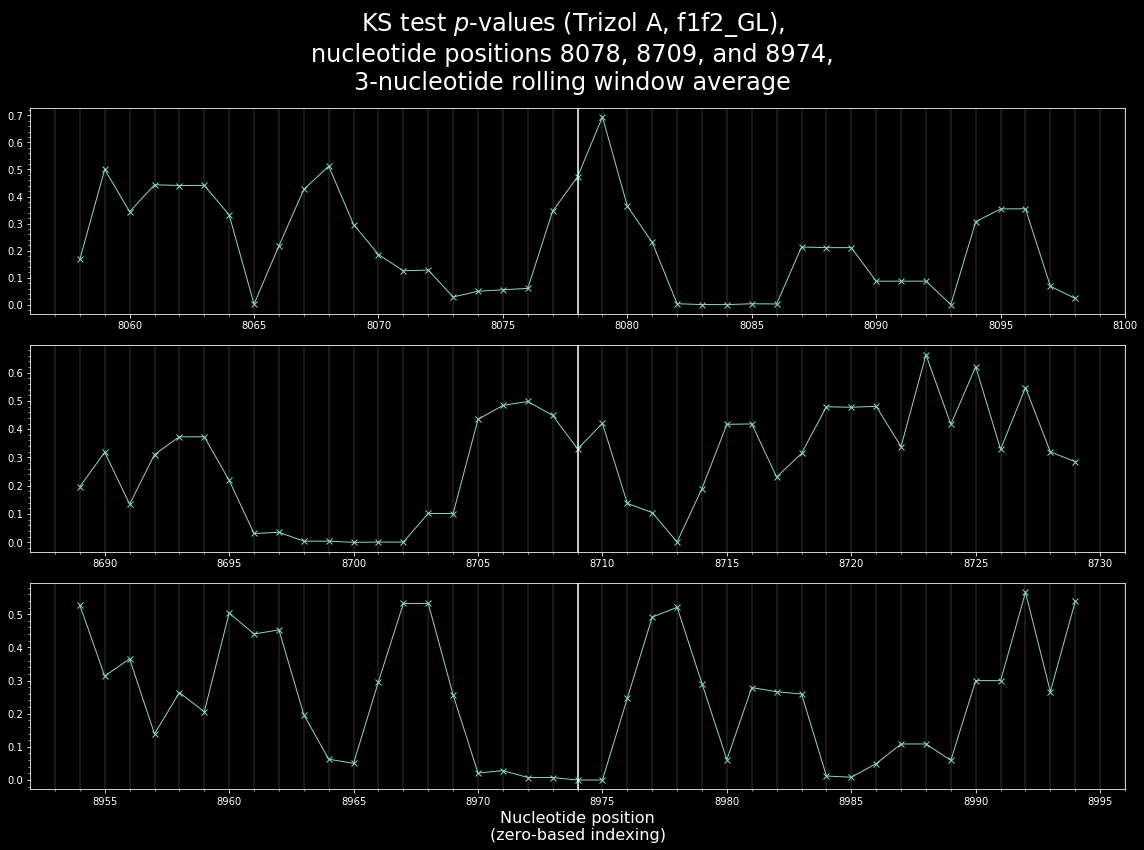

In [367]:
centers = [8078, 8709, 8974]
n = len(centers)

fig, axes = plt.subplots(n, 1, figsize=(16,4*n))

for center, ax in zip(centers, axes):
    radius = 20
    data_of_interest = ks_test_pvals_smoothed.loc[center - radius : center + radius]
    x = data_of_interest.index
    y = data_of_interest

    formatting_args = {'linestyle': '-', 'marker': 'x', 'linewidth':1}
    ax.plot(x, y, **formatting_args)

    ax.minorticks_on()
    
    ax.grid(True, which='both', axis='x', linewidth='0.2')
    
    ax.axvline([center])
    
plt.xlabel('Nucleotide position\n(zero-based indexing)', fontsize=16)


fig.suptitle('KS test $p$-values (Trizol A, f1f2_GL),\n'
             'nucleotide positions {}, {}, and {},\n'
             '3-nucleotide rolling window average'.format(*centers),
             fontsize=24
            )

fig.tight_layout(rect=[0, 0, 1, 0.88])
plt.savefig('smoothed_ks_test_pvals_at_three_locations.png')